In [1]:
from __future__ import print_function

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import datetime as datetime

%load_ext tensorboard

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)

(60000, 28, 28)


In [3]:
img_rows, img_cols = 28, 28

x_train_reshape = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test_reshape = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [4]:
# input image dimensions
x_train_reshape = x_train_reshape.astype('float32')
x_test_reshape = x_test_reshape.astype('float32')

x_train_reshape /= 255
x_test_reshape /= 255

print('x_train shape:', x_train.shape)
print(x_train_reshape.shape[0], 'train samples')
print(x_test_reshape.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [5]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test =to_categorical(y_test, 10)

In [6]:
model = Sequential()

model.add(Conv2D(4, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 kernel_initializer='he_normal',))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

In [7]:
import os
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = TensorBoard(logdir)

In [8]:
history= model.fit(x_train_reshape, y_train,
          epochs=5,
          verbose=1,
          validation_data=(x_test_reshape, y_test),
          #callbacks=[tensorboard_callback]
                  )

# 8 minutes on GPU P1000
# 2 minutes on 2080TX

#val_accuracy: 0.9877

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 158us/sample - loss: 0.2569 - accuracy: 0.9306 - val_loss: 0.1323 - val_accuracy: 0.9602
Epoch 2/5
60000/60000 [==============================] - 7s 116us/sample - loss: 0.1133 - accuracy: 0.9671 - val_loss: 0.0963 - val_accuracy: 0.9704
Epoch 3/5
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0882 - accuracy: 0.9744 - val_loss: 0.0919 - val_accuracy: 0.9717
Epoch 4/5
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0730 - accuracy: 0.9783 - val_loss: 0.0839 - val_accuracy: 0.9744
Epoch 5/5
60000/60000 [==============================] - 7s 120us/sample - loss: 0.0636 - accuracy: 0.9808 - val_loss: 0.0858 - val_accuracy: 0.9726


In [9]:
score = model.evaluate(x_test_reshape, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08579689360838383
Test accuracy: 0.9726


In [10]:
# Adam optimizer with he_normal:
#Test loss: 0.03299637805730106
#Test accuracy: 0.9916
    
# Adadelta with normal optimizer
#Test loss: 0.3832157447218895
#Test accuracy: 0.8958

# Added model.add(Conv2D(128, (3, 3), activation='relu')) and remove dropout
#Test loss: 0.04446429884471263
#Test accuracy: 0.9915

<h2> Visualize Layers</h2>

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                27050     
Total params: 27,090
Trainable params: 27,090
Non-trainable params: 0
_________________________________________________________________


<h3> Visualizing Filters </h3>

In [12]:
import matplotlib.pyplot as plt

for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (3, 3, 1, 4)


In [13]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

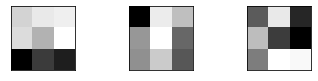

In [14]:
# plot first few filters
n_filters, ix = 3, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

<h3> Visualizing Features Maps </h3>

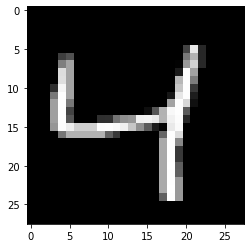

In [15]:
from tensorflow.keras.models import Model

# Extract an image and visualize its value

sample_mnsit = x_train[2]
plt.imshow(sample_mnsit, cmap='gray')

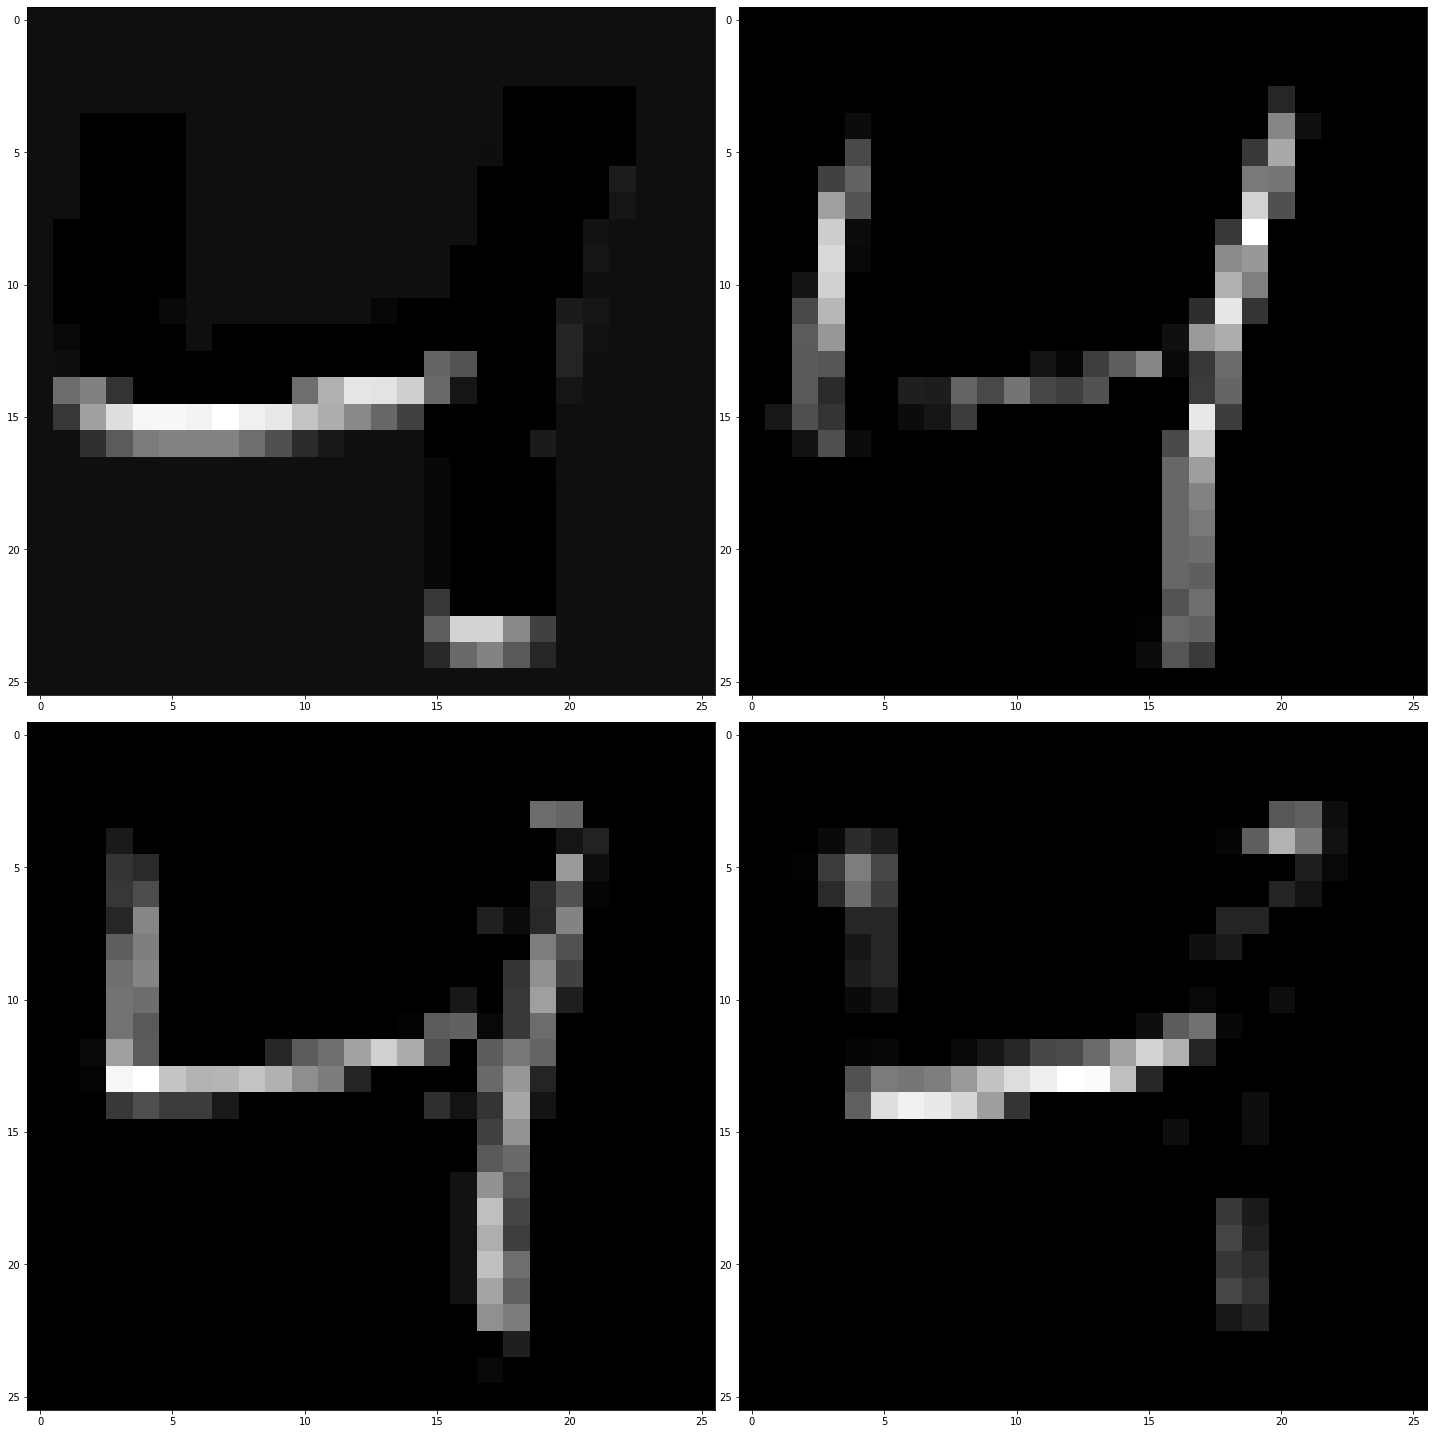

In [16]:
# fresh copy of image
sample_mnsit = x_train[2]

# Reshape to fit classifier
sample_mnsit = sample_mnsit.reshape(1, img_rows, img_cols, 1)

#Convert to flaot32
sample_mnsit = sample_mnsit.astype('float32')

# Normalizr features
sample_mnsit /= 255

# Input layer number you want to extract the feature maps from
layer_no = 0

# Get the filters from the first layer
modified_model = Model(inputs=model.inputs, outputs=model.layers[layer_no].output)

# Apply filters to image to get activation function
feature_maps  = modified_model.predict(sample_mnsit)

# Plot graph of each feature map
nrows = int(feature_maps.shape[-1] / 2)
ncols = 2
fig, axs = plt.subplots(nrows,ncols, 
                        figsize=(20, 20), 
                        facecolor='w', 
                        edgecolor='k',
                       )

axs = axs.ravel()


for i in range(feature_maps.shape[-1]):

    axs[i].imshow(feature_maps[0, :, :, i], cmap='gray')

plt.tight_layout(True)
plt.show()

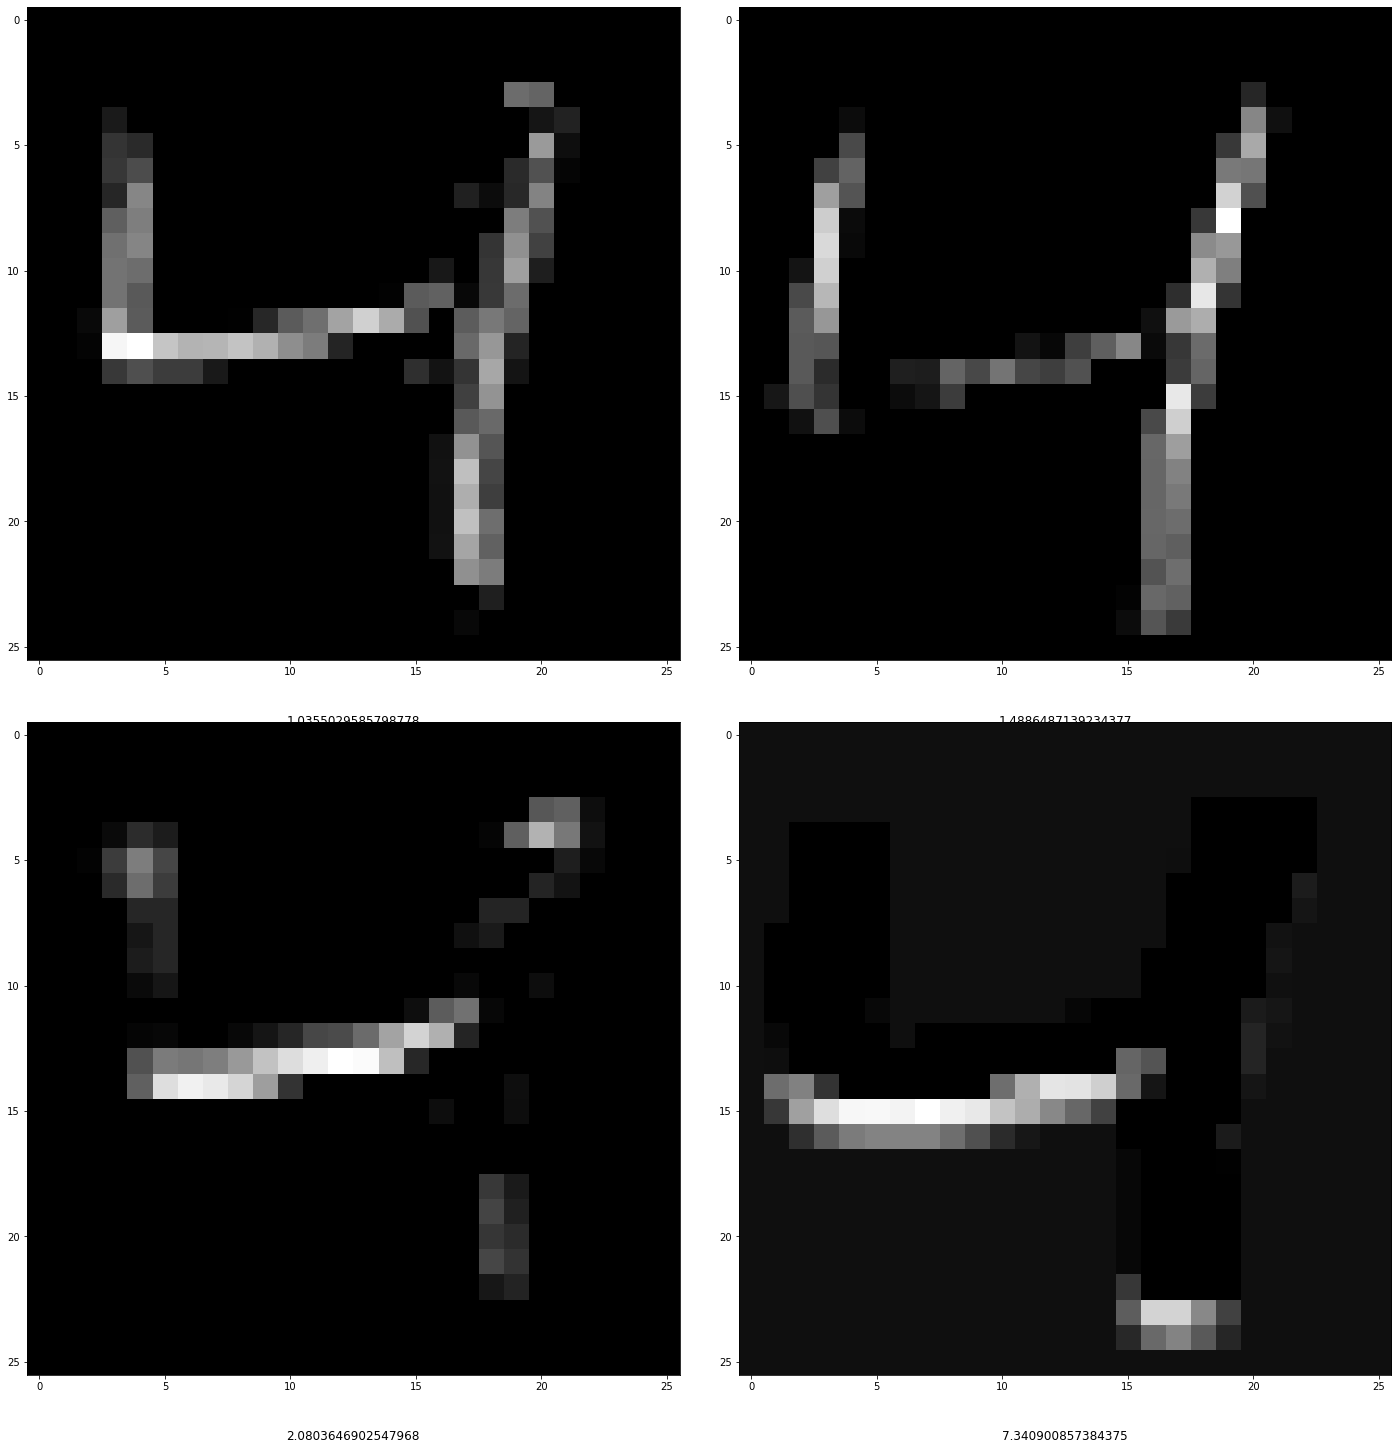

In [17]:
import cv2, numpy as np
from sklearn.cluster import KMeans

# Get the top dominat colors by percentage
def get_cluser(image):
    reshape = image.reshape((image.shape[0] * image.shape[1], 1))
    cluster = KMeans(n_clusters=5).fit(reshape)
    
    return cluster, cluster.cluster_centers_


def visualize_colors(image):
    
    cluster, centroids = get_cluser(image)
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    
    return [percent*100 for (percent, color) in colors]
        


# Get the top 5 dominant color of the original image
original_image = visualize_colors(x_train[2])

# Get the top 5 dominant colors of the feature maps, subtract from original image
# Get mean value of the 5 differnce 

mean_value_diff = []
for x in range(feature_maps.shape[-1]):
    feature_map = visualize_colors(feature_maps[0, :, :, x])
    mean_value_diff.append(np.mean([np.abs(a_i - b_i) for a_i, b_i in zip(original_image, feature_map)]))
    
# values of sorted top feature maps
top_similair_features_values= sorted(mean_value_diff)

# index of sorted top feature maps with similiar value
top_similair_features_index = sorted(range(len(mean_value_diff)), key=lambda k: mean_value_diff[k])


# Plot top similiar features with original image
fig, axs = plt.subplots(nrows,ncols, 
                        figsize=(20, 20), 
                        facecolor='w', 
                        edgecolor='k',
                       )

axs = axs.ravel()



for i in range(feature_maps.shape[-1]):

    axs[i].imshow(feature_maps[0, :, :, top_similair_features_index[i]], cmap='gray')
    axs[i].text(0.5,-0.1, top_similair_features_values[i], size=12, ha="center", 
             transform=axs[i].transAxes)
plt.tight_layout(True)
plt.show()
